In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.getOrCreate()

# Read the Parquet file
df = spark.read.parquet("working_data/Filtered_Fish_Data.parquet")

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/07/08 10:20:47 WARN Utils: Your hostname, codespaces-6557a2, resolves to a loopback address: 127.0.0.1; using 10.0.3.194 instead (on interface eth0)
25/07/08 10:20:47 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/07/08 10:20:48 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
df.show(5)

+---------+---------------+----------+------------+--------------------+-----------------+----------------------+---------------------+-----------+--------+
|SURVEY_ID|EVENT_DATE_YEAR|SPECIES_ID|SPECIES_NAME|          LATIN_NAME|SURVEY_RANKED_NGR|SURVEY_RANKED_NORTHING|SURVEY_RANKED_EASTING|FISH_LENGTH|AGE_BAND|
+---------+---------------+----------+------------+--------------------+-----------------+----------------------+---------------------+-----------+--------+
|   111032|           1989|       196|        Rudd|Scardinius erythr...|     SE5530009200|                409200|               455300|        142|     >4+|
|    72230|           2002|       196|        Rudd|Scardinius erythr...|     SE7920071500|                471500|               479200|         29|      0+|
|    51949|           2001|       196|        Rudd|Scardinius erythr...|     SU5880008700|                108700|               458800|        157|      0+|
|    67760|           2001|       196|        Rudd|Scardin

In [3]:
df.printSchema()

root
 |-- SURVEY_ID: integer (nullable = true)
 |-- EVENT_DATE_YEAR: long (nullable = true)
 |-- SPECIES_ID: integer (nullable = true)
 |-- SPECIES_NAME: string (nullable = true)
 |-- LATIN_NAME: string (nullable = true)
 |-- SURVEY_RANKED_NGR: string (nullable = true)
 |-- SURVEY_RANKED_NORTHING: long (nullable = true)
 |-- SURVEY_RANKED_EASTING: long (nullable = true)
 |-- FISH_LENGTH: integer (nullable = true)
 |-- AGE_BAND: string (nullable = true)



In [ ]:
from pyspark.sql.functions import col

filtered_df = df.filter(
    (col("SURVEY_RANKED_NORTHING") >= 375000) &
    (col("SURVEY_RANKED_NORTHING") <= 400000) &
    (col("SURVEY_RANKED_EASTING") > 620000)
)

filtered_df.show()
filtered_df.count()


+---------+---------------+----------+------------+-----------+-----------------+----------------------+---------------------+-----------+--------+
|SURVEY_ID|EVENT_DATE_YEAR|SPECIES_ID|SPECIES_NAME| LATIN_NAME|SURVEY_RANKED_NGR|SURVEY_RANKED_NORTHING|SURVEY_RANKED_EASTING|FISH_LENGTH|AGE_BAND|
+---------+---------------+----------+------------+-----------+-----------------+----------------------+---------------------+-----------+--------+
|    17078|           1987|       193|     Gudgeon|Gobio gobio|     TG4880092400|                392400|               648800|        117|    NULL|
|    17078|           1987|       193|     Gudgeon|Gobio gobio|     TG4880092400|                392400|               648800|        130|    NULL|
|    17078|           1987|       193|     Gudgeon|Gobio gobio|     TG4880092400|                392400|               648800|         90|    NULL|
|    17078|           1987|       193|     Gudgeon|Gobio gobio|     TG4880092400|                392400|        

219

In [ ]:
df = df.subtract(filtered_df)

In [5]:
from pyspark.sql.functions import col

summary_data = []
for c in df.columns:
    total = df.select(c).count()
    uniques = df.select(c).distinct().count()
    summary_data.append((c, total, uniques))

# Print header
print(f"{'Column':<25} | {'Count of values':<15} | {'Unique Entries':<10}")
print("-" * 60)

# Print each line aligned
for col_name, total, uniques in summary_data:
    print(f"{col_name:<25} | {total:<15} | {uniques:<10}")

# Count of all SPECIES_ID
species_counts_pre = df.groupBy("SPECIES_NAME").count().orderBy("SPECIES_NAME")
species_counts_pre.show()

Column                    | Count of values | Unique Entries
------------------------------------------------------------
SURVEY_ID                 | 4915478         | 30550     
EVENT_DATE_YEAR           | 4915478         | 49        
SPECIES_ID                | 4915478         | 13        
SPECIES_NAME              | 4915478         | 13        
LATIN_NAME                | 4915478         | 12        
SURVEY_RANKED_NGR         | 4915478         | 11884     
SURVEY_RANKED_NORTHING    | 4915478         | 9183      
SURVEY_RANKED_EASTING     | 4915478         | 9037      
FISH_LENGTH               | 4915478         | 1019      
AGE_BAND                  | 4915478         | 63        
+--------------+-------+
|  SPECIES_NAME|  count|
+--------------+-------+
|        Barbel|  18114|
|         Bleak| 191489|
|          Chub| 313478|
|  Common bream| 221743|
|          Dace| 447320|
|      Grayling|  41497|
|       Gudgeon| 365174|
|         Perch| 403475|
|          Pike| 109605|
|Pike va

In [4]:
from pyspark.sql.functions import when

df = df.withColumn(
    "SPECIES_ID",
    when(col("SPECIES_ID") == 212, 213).otherwise(col("SPECIES_ID"))
).withColumn(
    "SPECIES_NAME",
    when(col("SPECIES_NAME") == "Pike varieties", "Pike").otherwise(col("SPECIES_NAME"))
)

species_counts_post = df.groupBy("SPECIES_NAME").count().orderBy("SPECIES_NAME")
species_counts_post.show()

+------------+-------+
|SPECIES_NAME|  count|
+------------+-------+
|      Barbel|  18114|
|       Bleak| 191489|
|        Chub| 313478|
|Common bream| 221743|
|        Dace| 447320|
|    Grayling|  41497|
|     Gudgeon| 365174|
|       Perch| 403475|
|        Pike| 112687|
|       Roach|2666270|
|        Rudd|  38638|
|Silver bream|  95593|
+------------+-------+



25/07/08 09:43:41 WARN Instrumentation: [09f347ae] regParam is zero, which might cause numerical instability and overfitting.


Test RMSE: 27.00
Test R²: 0.009


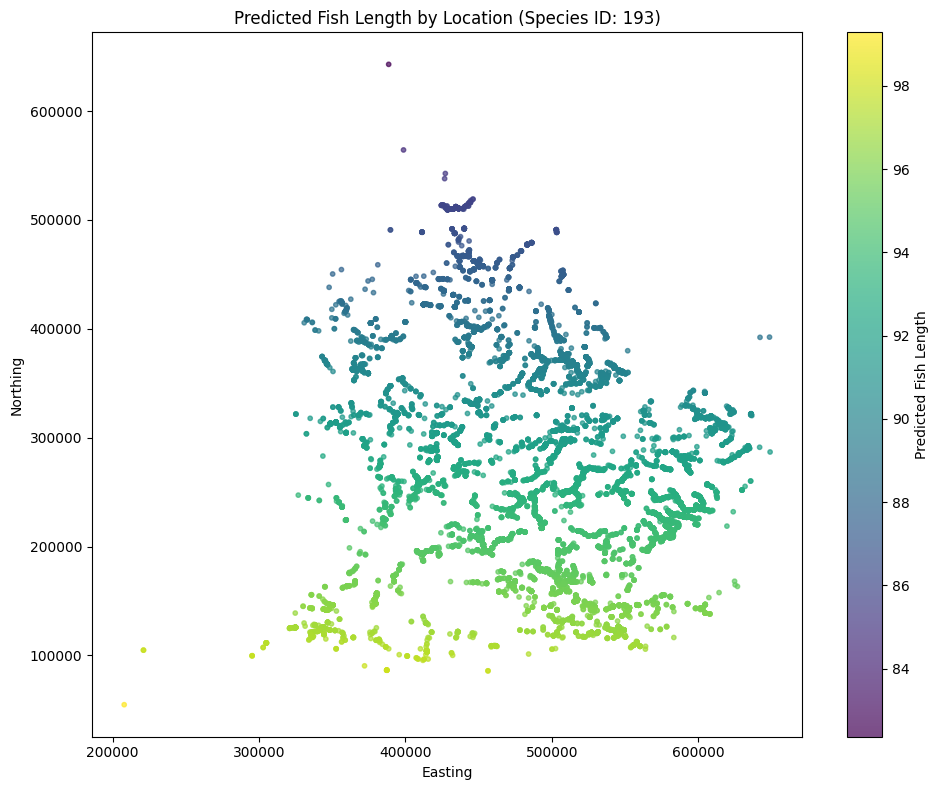

In [8]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.sql.functions import col
import matplotlib.pyplot as plt

# Get list of unique species
species_list = [row["SPECIES_ID"] for row in df.select("SPECIES_ID").distinct().collect()]

# Choose a species to analyze (change as needed)
species_to_plot = species_list[0]

# Filter for one species
df_species = df.filter(col("SPECIES_ID") == species_to_plot).dropna(subset=["SURVEY_RANKED_NORTHING", "SURVEY_RANKED_EASTING", "FISH_LENGTH"])

# Assemble features
assembler = VectorAssembler(
    inputCols=["SURVEY_RANKED_NORTHING", "SURVEY_RANKED_EASTING"],
    outputCol="features"
)
df_features = assembler.transform(df_species)

# Split into train/test sets
train_df, test_df = df_features.randomSplit([0.8, 0.2], seed=42)

# Fit regression model on training data
lr = LinearRegression(featuresCol="features", labelCol="FISH_LENGTH")
model = lr.fit(train_df)

# Predict on test set
test_predictions = model.transform(test_df)

# Evaluate model performance on test set
from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator(
    labelCol="FISH_LENGTH", predictionCol="prediction", metricName="rmse"
)
rmse = evaluator.evaluate(test_predictions)
r2 = evaluator.setMetricName("r2").evaluate(test_predictions)
print(f"Test RMSE: {rmse:.2f}")
print(f"Test R²: {r2:.3f}")

# Collect a sample of test predictions for plotting
pred_pd = test_predictions.select(
    "SURVEY_RANKED_EASTING", "SURVEY_RANKED_NORTHING", "FISH_LENGTH", "prediction"
).sample(fraction=0.2, seed=42).toPandas()  # Adjust fraction as needed

plt.figure(figsize=(10, 8))
sc = plt.scatter(
    pred_pd["SURVEY_RANKED_EASTING"],
    pred_pd["SURVEY_RANKED_NORTHING"],
    c=pred_pd["prediction"],
    cmap="viridis",
    s=10,
    alpha=0.7
)
plt.colorbar(sc, label="Predicted Fish Length")
plt.xlabel("Easting")
plt.ylabel("Northing")
plt.title(f"Predicted Fish Length by Location (Species ID: {species_to_plot})")
plt.tight_layout()
plt.show()

### Example flow to generate an interactive map using folium

#### Initial step to transform coordinates from British National Grid coordinates (EPSG:27700), to Folium accepted coordinates of latitude/longitude (EPSG:4326)

```python
from pyproj import Transformer

transformer = Transformer.from_crs("epsg:27700", "epsg:4326", always_xy=True)
pred_pd["lon"], pred_pd["lat"] = transformer.transform(
    pred_pd["SURVEY_RANKED_EASTING"].values, pred_pd["SURVEY_RANKED_NORTHING"].values
)
```

#### Using folium to generate an interactive map

```python
import folium

# Center map on England
m = folium.Map(location=[54, -2], zoom_start=6)

# Add points
for _, row in pred_pd.iterrows():
    folium.CircleMarker(
        location=[row["lat"], row["lon"]],
        radius=3,
        color=None,
        fill=True,
        fill_color=plt.cm.viridis((row["prediction"] - pred_pd["prediction"].min()) / (pred_pd["prediction"].max() - pred_pd["prediction"].min())),
        fill_opacity=0.7,
        popup=f"Predicted Length: {row['prediction']:.1f}"
    ).add_to(m)

m.save("fish_length_map.html")
```

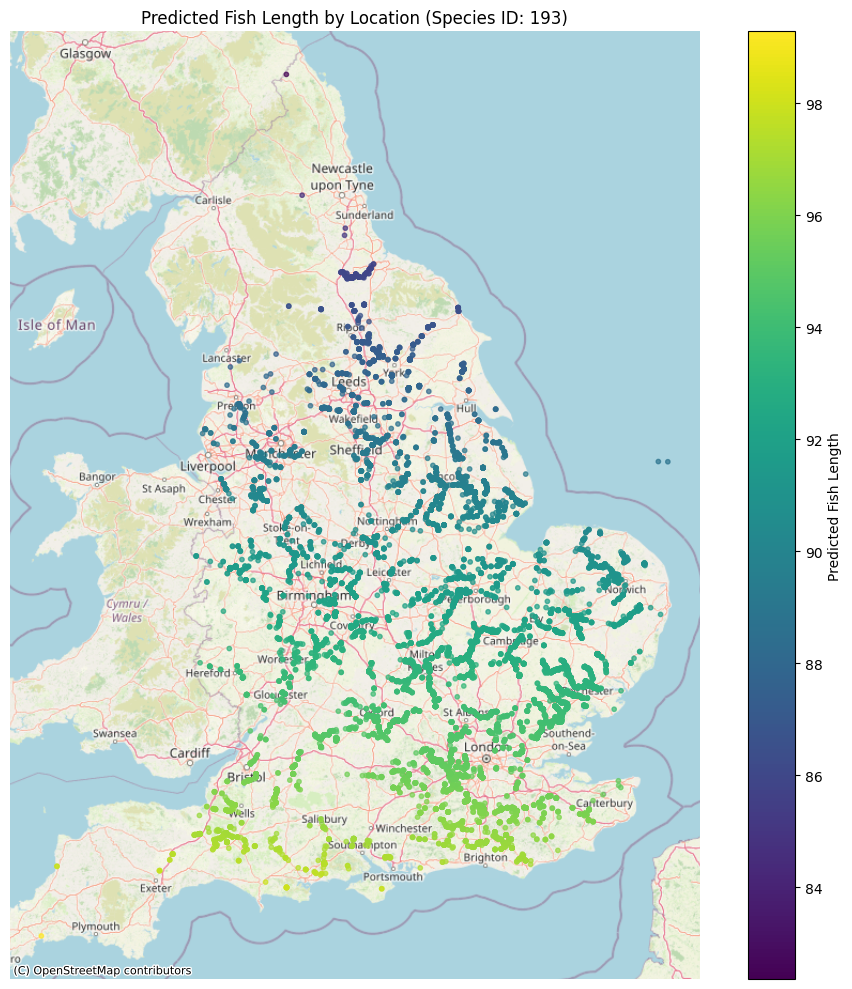

In [ ]:
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import contextily as ctx

# 1. Create GeoDataFrame from pred_pd DataFrame
gdf = gpd.GeoDataFrame(
    pred_pd,
    geometry=[Point(xy) for xy in zip(pred_pd["lon"], pred_pd["lat"])],
    crs="EPSG:4326"  # WGS84
)

# 2. Project to Web Mercator for contextily
gdf = gdf.to_crs(epsg=3857)

# 3. Plot with basemap and colorbar
fig, ax = plt.subplots(figsize=(10, 10))
sc = gdf.plot(
    ax=ax,
    column="prediction",
    cmap="viridis",
    markersize=10,
    alpha=0.7,
    legend=True,
    legend_kwds={'label': "Predicted Fish Length"}
)
# Use a widely supported basemap
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
ax.set_axis_off()
plt.title(f"Predicted Fish Length by Location (Species ID: {species_to_plot})")
plt.tight_layout()
plt.show()